In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import correlate # cross-correlation
from scipy.stats import t
import sys
sys.path.append("..")

from src.utils import add_zero
from src.utils import fix_colnames

In [2]:
data = pd.read_csv("../data/PRSA_data_2010.1.1-2014.12.31.csv")

In [3]:
data.columns = fix_colnames(data.columns)

In [4]:
print(data.shape)
data.head()

(43824, 13)


,no,year,month,day,hour,pm2_5,dewp,temp,pres,cbwd,iws,is,ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
# Build date column: format Y-m-d H:m
data["month"] = data["month"].apply(add_zero)
data["day"]   = data["day"].apply(add_zero)
data["hour"]  = data["hour"].apply(add_zero)

date_str = (
    data["year"].astype(str) + "-" + 
    data["month"] + "-" + 
    data["day"] + " " + 
    data["hour"] + ":00"
)

data["date"] = pd.to_datetime(date_str)

In [6]:
# Remove missing values
data = data.dropna(subset=["pm2_5"])

In [7]:
# cbwd has these categories: SE, NW, NE and cv
# we can suppose that cv is SW
data["cbwd"] = data["cbwd"].replace({"cv": "SW"})

In [8]:
# drop some columns
cols_drop = ["no", "year", "day"]
data = data.drop(columns=cols_drop)

In [9]:
print(data.shape)
data.head()

(41757, 11)


,month,hour,pm2_5,dewp,temp,pres,cbwd,iws,is,ir,date
24,01,00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
25,01,01,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
26,01,02,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
27,01,03,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
28,01,04,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


### Visualization of the serie

In [10]:
target_str = "pm2_5"

In [11]:
data.agg({"date": ["min", "max"]})

,date
min,2010-01-02 00:00:00
max,2014-12-31 23:00:00


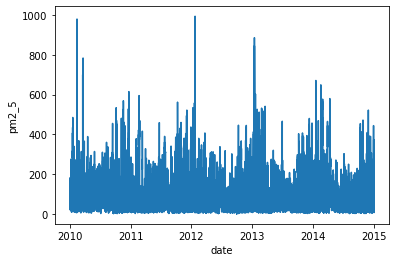

In [12]:
ax = sns.lineplot(x="date", y=target_str, data=data)
plt.show()

### Autocorrelation (ACF) and Partial-autocorrelation (ACFP) functions

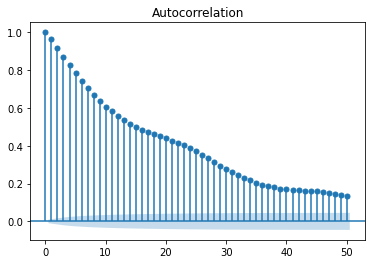

In [13]:
plot_acf(x=data[target_str], lags=50)
plt.show()

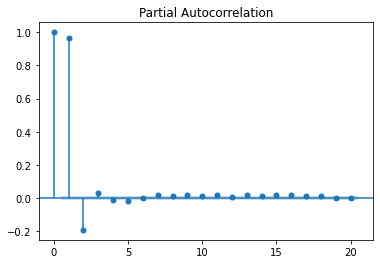

In [14]:
plot_pacf(x=data[target_str], lags=20)
plt.show()

This behaviour seem like an AR(2) model. We can use the last two lags as features for the regression approach.

### Cross-correlation

In [16]:
def ccf(x, y, lag_max = 50):

    result = correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    length = (len(result) - 1) // 2
    lo = length + 1
    hi = length + (lag_max + 1)

    return result[lo:hi]

# source: https://online.stat.psu.edu/stat501/lesson/1/1.9
def compute_rho_theoric(t_val, n):
    return np.sqrt((t_val ** 2) / ((t_val ** 2) + n - 2))

In [17]:
features = ["dewp", "temp", "pres", "iws"]
#var = features[0]

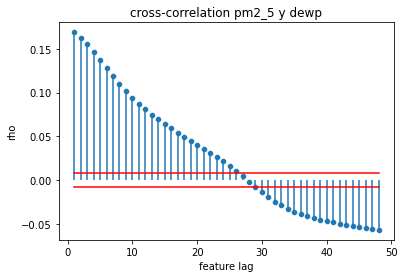

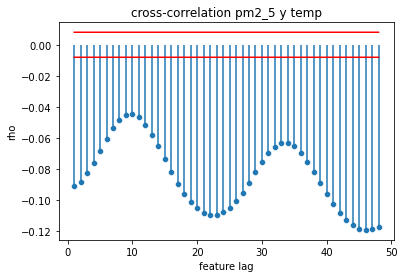

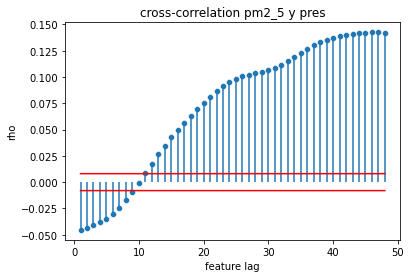

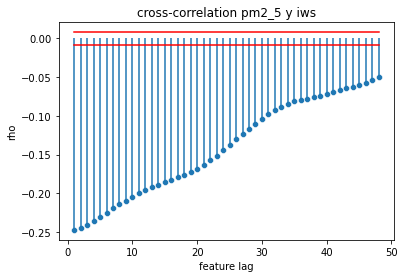

In [18]:
lag_max = 48

for var in features:
    
    corr_result = ccf(x=data[var], y=data[target_str], lag_max=lag_max)

    # test hypothesis
    alpha = 0.05
    n_total = len(data[var])
    rho_theoric = [compute_rho_theoric(t_val=t.ppf(1-alpha, n_total-i), n=n_total-i) for i in range(1, lag_max + 1)]

    # visualization
    ax = sns.scatterplot(x=range(1, lag_max + 1), y=corr_result)
    sns.lineplot(x=range(1, lag_max + 1), y=-1* np.array(rho_theoric), color="red")
    sns.lineplot(x=range(1, lag_max + 1), y=rho_theoric, color="red")
    plt.vlines(x=range(1, lag_max + 1), ymin= 0, ymax=corr_result)
    plt.xlabel("feature lag")
    plt.ylabel("rho")
    plt.title("cross-correlation " + target_str + " y " + var)
    plt.show()

**We can see several interesting things here:**

1. The dew point one hour before is positve correlated with the $pm_{2.5}$
2. The temperature one hour before (even 23 hours before) is negative correlated with the $pm_{2.5}$. It means, less temperature more $pm_{2.5}$ one hour after.
3. The pressure (pres) one hour before is negative correlated and 12 hours before is positive correlated with $pm_{2.5}$, it means if the pressure decrease, the $pm_{2.5}$ increases one hour after. 
4. The wind speed one hour before is positve correlated with the $pm_{2.5}$

## Graph exploration

### Analysis by hour

In [19]:
data["pm2_5"].quantile([0.5, 0.75, 0.9, 0.95, 1])

0.50     72.0
0.75    137.0
0.90    221.0
0.95    284.0
1.00    994.0
Name: pm2_5, dtype: float64

Trunquemos los valores a 300 (percentil 95) para realizar la visualizacion

<AxesSubplot:xlabel='hour', ylabel='pm2_5'>

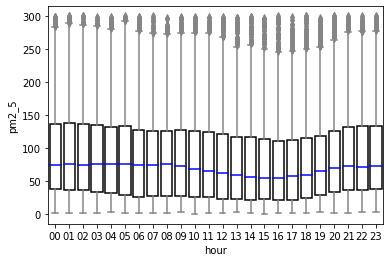

In [20]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'blue'},
}
sns.boxplot(x="hour",
            y="pm2_5", 
            data=data.query("pm2_5 <= 300"),
            color="#BDC7FE",
            **PROPS)

We can see that median level of $pm_{2.5}$ is the lowest between 15:00 and 16:00. The other hand, the highest value is around 21:00.

### Analysis by day

In [21]:
data["day_name"] = data["date"].dt.strftime("%a")

<AxesSubplot:xlabel='day_name', ylabel='pm2_5'>

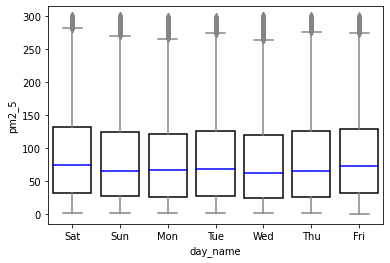

In [22]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'blue'},
}

sns.boxplot(x="day_name",
            y="pm2_5",
            data=data.query("pm2_5 <= 300"),
            color="#BDC7FE",
            **PROPS)

In this case, we can see the wednesday the lowest median $pm_{2.5}$ value. On Saturdays we can see the highest median value.

### We can do a better analysis by day and hour: Looking for seasonal behaviour

In [23]:
data = data.set_index("date")

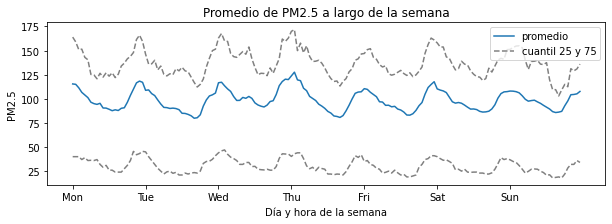

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
promedio_dia_hora = data.groupby(["day_name", "hour"])["pm2_5"].mean()
q25_dia_hora = data.groupby(["day_name", "hour"])["pm2_5"].quantile(0.25)
q75_dia_hora = data.groupby(["day_name", "hour"])["pm2_5"].quantile(0.75)

promedio_dia_hora.plot(ax=ax, label='promedio')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Promedio de PM2.5 a largo de la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora de la semana",
    ylabel="PM2.5"
)

ax.legend();

We can see a pattern intra-day, as we see before in the hour analysis. It means that the hour could be a good feature in order to forecast the *pm2.5*.

---